In [1]:
!pip install yfinance --upgrade --no-cache-dir 

     |████████████████████████████████| 63 kB 791 kB/s             
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.1.67
    Uninstalling yfinance-0.1.67:
      Successfully uninstalled yfinance-0.1.67
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.


### Importing all the necessary libraries which are required to implement

In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import yfinance as yf

### Reading the past 10 years of daily Gold ETF price data and store it in DataFrame
#### Plotting the CLOSE prices of Gold

[*********************100%***********************]  1 of 1 completed


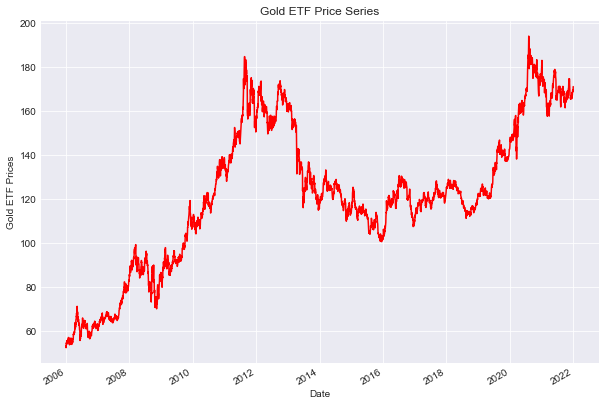

In [27]:
# Read data
Df = yf.download('GLD', '2006-01-01', '2022-01-03', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

### Viewing the Dataframe collected from ticker/index

In [28]:
Df

,Close
Date,
2006-01-03,53.119999
2006-01-04,53.299999
2006-01-05,52.340000
2006-01-06,53.720001
2006-01-09,54.599998
...,...
2021-12-27,169.369995
2021-12-28,168.639999
2021-12-29,168.589996


### Some EDA on Data Collected

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

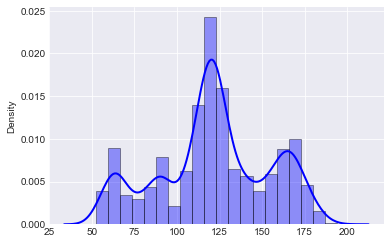

In [29]:
#Create histogram with density plot
import seaborn as sns
sns.distplot(Df, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

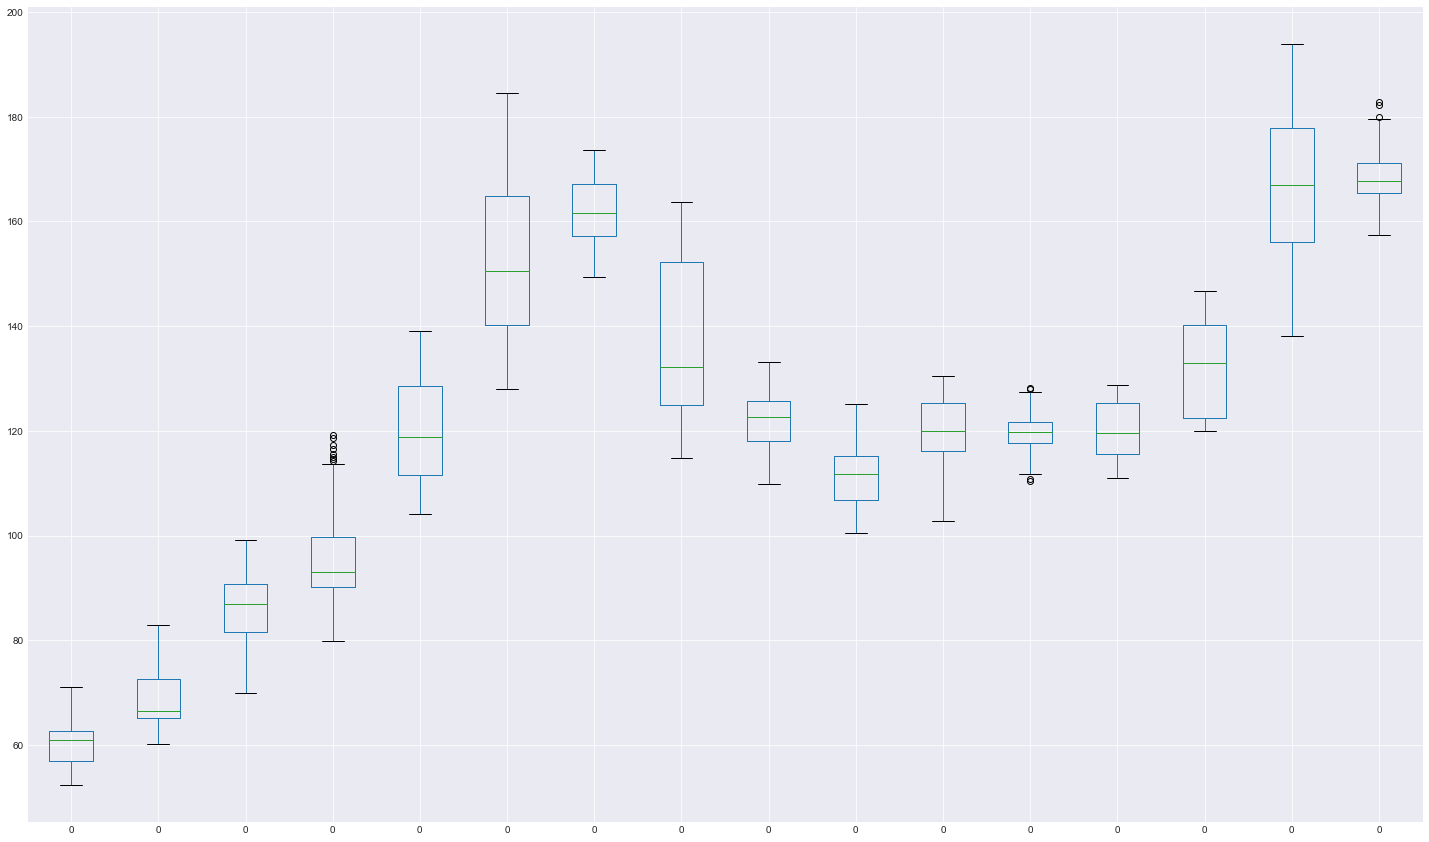

In [30]:
# yearly Box-Plot on Data
single_year = Df
groups = single_year.groupby(pd.Grouper(freq='A'))
years = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
years = pd.DataFrame(years)
years.boxplot(figsize=(25,15))
plt.show()

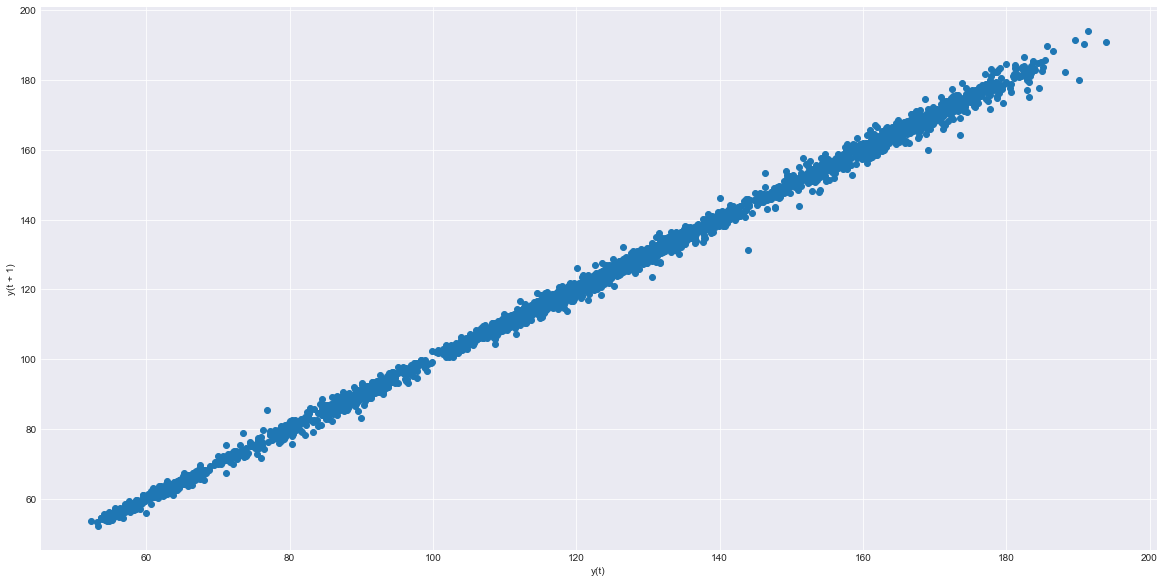

In [31]:
# create a scatter plot
from pandas.plotting import lag_plot
plt.figure(figsize=(20,10))
lag_plot(Df)
plt.show()

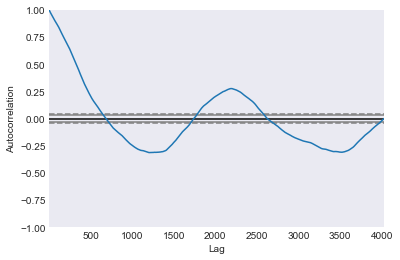

In [32]:
# Creating Autocorrelation plot
pd.plotting.autocorrelation_plot(Df)
plt.show()

### Explantory Variable = variable which is manipulated to determind the next day price of commodity
### Dependant Valriable = which depends upon value of explanatory variable (Gold Price in this case)
#### S3 = moving avg of last 3 days
#### S9 = moving avg of last 15 Days
#### y where we will store our Gold Price

In [33]:
# Define explanatory variables
Df['S3'] = Df['Close'].rolling(window=3).mean()
Df['S15'] = Df['Close'].rolling(window=15).mean()
Df['next_day_price'] = Df['Close'].shift(-1)

Df = Df.dropna()
X = Df[['S3', 'S15']]

# Define dependent variable
y = Df['next_day_price']

In [34]:
Df

,Close,S3,S15,next_day_price
Date,,,,
2006-01-24,55.730000,55.566667,54.477333,56.139999
2006-01-25,56.139999,55.880000,54.678666,55.880001
2006-01-26,55.880001,55.916667,54.850667,55.630001
2006-01-27,55.630001,55.883334,55.070000,56.680000
2006-01-30,56.680000,56.063334,55.267333,56.700001
...,...,...,...,...
2021-12-23,168.970001,168.193334,167.016000,169.369995
2021-12-27,169.369995,168.976664,167.198666,168.639999
2021-12-28,168.639999,168.993332,167.360000,168.589996


### Splitting Data for Test & Training. Test Data to be used for Linear Regression Model
#### - First 80% of the data is used for training and remaining data for testing

In [35]:
# Split the data into train and test dataset
t = .8
t = int(t*len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

### Y = m1 * X1 + m2 * X2 + C
### Gold ETF price = m1 * 3 days moving average + m2 * 15 days moving average + c

In [36]:
# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold ETF Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 15 Days Moving Average (x2) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression model
Gold ETF Price (y) = 1.10 * 3 Days Moving Average (x1) + -0.10 * 15 Days Moving Average (x2) + 0.30 (constant)


### Predict the Gold ETF prices

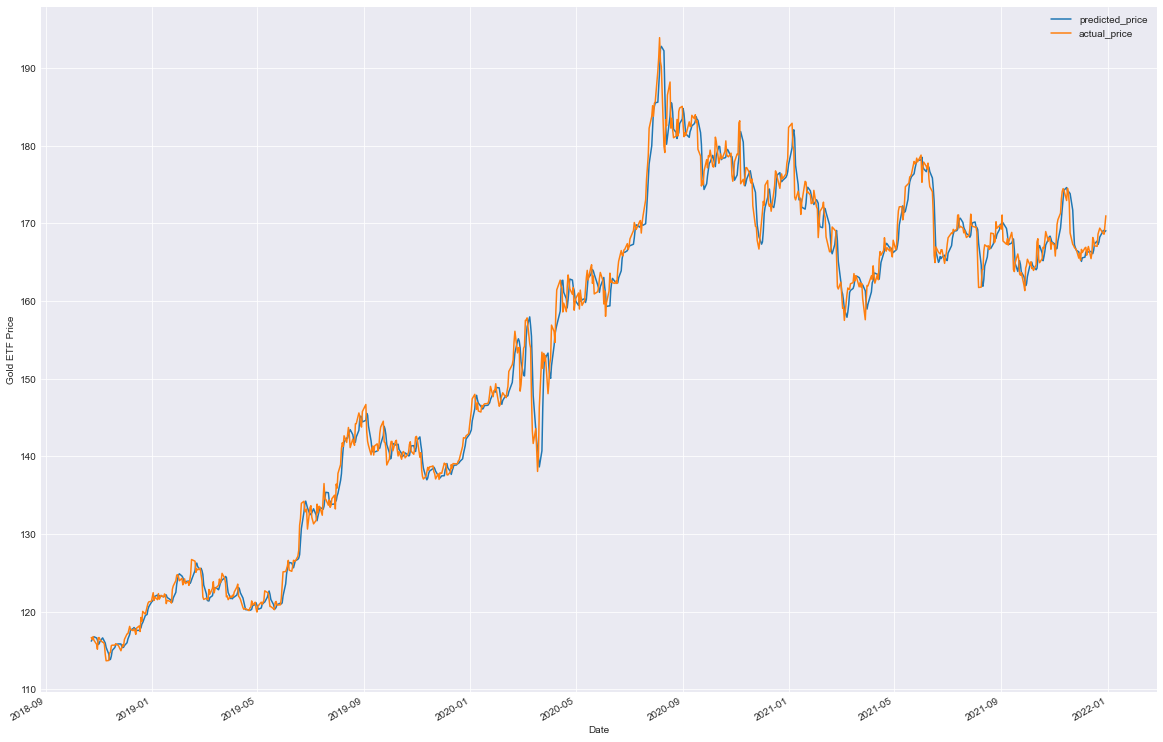

In [37]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(20, 14))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

### Computing the goodness of the fit

In [38]:
# R square
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

99.12

### Plotting cumulative returns

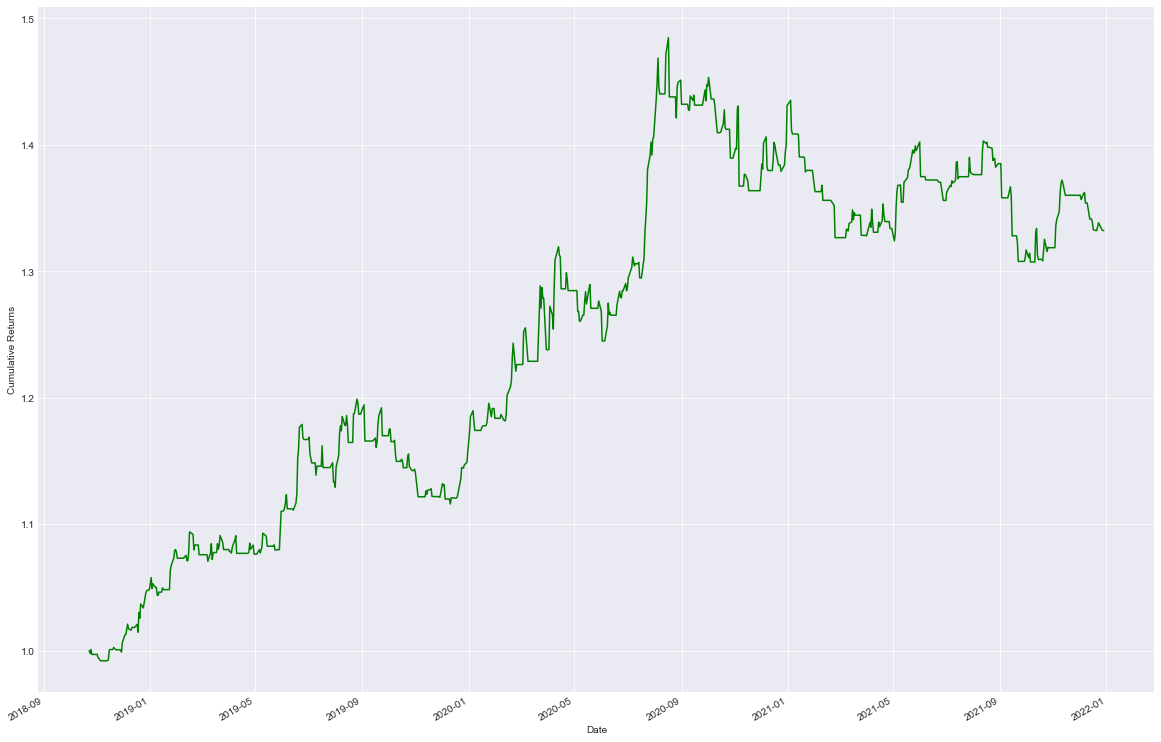

In [39]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(20,14),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

#### A 'buy' trading signal represented by “1” when the next day’s predicted price is more than the current day predicted price. No position is taken otherwise

In [40]:
gold

,price,predicted_price_next_day,actual_price_next_day,gold_returns,signal,strategy_returns
Date,,,,,,
2018-10-23,116.389999,116.189158,116.660004,0.002320,0,0.000000
2018-10-24,116.660004,116.405371,116.400002,-0.002229,1,-0.002229
2018-10-25,116.400002,116.638471,116.769997,0.003179,1,0.003179
2018-10-26,116.769997,116.757452,116.309998,-0.003939,1,-0.003939
2018-10-29,116.309998,116.602997,115.800003,-0.004385,0,-0.000000
...,...,...,...,...,...,...
2021-12-23,168.970001,168.209271,169.369995,0.002367,1,0.002367
2021-12-27,169.369995,169.052846,168.639999,-0.004310,1,-0.004310
2021-12-28,168.639999,169.054508,168.589996,-0.000297,1,-0.000297


### Calculating Sharpe Ratio
#### Sharpe ratio is the measure of risk-adjusted return of a financial portfolio.

In [41]:
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 0.90'

### Predict daily moves as per signal created

In [42]:
# import datetime and get today's date
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2007-01-01', current_date, auto_adjust=True)
data['S3'] = data['Close'].rolling(window=3).mean()
data['S15'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S3', 'S15']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T

[*********************100%***********************]  1 of 1 completed


/var/folders/k5/lwkgygfs2q3fg49l_twlbgph0000gn/T/ipykernel_56563/1652013103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_gold_price'] = linear.predict(data[['S3', 'S15']])
/var/folders/k5/lwkgygfs2q3fg49l_twlbgph0000gn/T/ipykernel_56563/1652013103.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")


Date,2022-01-03
signal,No Position
predicted_gold_price,169.667646


## Model Training: Random Forest Regressor

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [44]:
regressor = RandomForestRegressor(n_estimators=100)

In [45]:
regressor.fit(X_train,y_train)

RandomForestRegressor()

### Model Evaluation

In [46]:
test_data_prediction = regressor.predict(X_test)

In [47]:
error_score = metrics.r2_score(y_test, test_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9837350790141256


### Comparing the Actual Values and the Predicted Values

In [48]:
y_test = list(y_test)

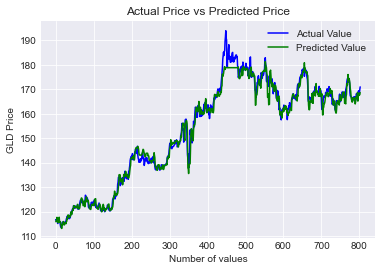

In [49]:
plt.plot(y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y

LR: nan (nan)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y

RFR: nan (nan)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y

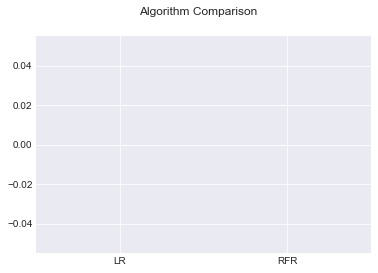

In [50]:
from sklearn import model_selection
# prepare configuration for cross validation test harness
seed = 7
X1 = Df[['S3', 'S15']]

# Define dependent variable
Y = Df['next_day_price']
# prepare models
models = []
models.append(('LR', linear))
models.append(('RFR', regressor))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X1, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()